In [ ]:
!unzip data.zip

In [10]:
# ## 1. Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# ---

# ## 2. Data Loading and Preprocessing
try:
    base_path = '/content/data'
    if not os.path.exists(base_path):
        raise FileNotFoundError

    image_paths = glob.glob(os.path.join(base_path, '*/*.jpg'))
    labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]
    df = pd.DataFrame({'path': image_paths, 'label': labels})

    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    class_names = list(le.classes_)
    print(f"Dataset loaded successfully. Found {len(df)} images.")

except FileNotFoundError:
    print(f"Error: Directory '{base_path}' not found. Please check the path.")
    df = pd.DataFrame()

Dataset loaded successfully. Found 41 images.


Original class counts:
 label
Setu Bandha Sarvangasana    11
Phalakasana                  8
Padmasana                    6
Virabhadrasana One           5
Baddha Konasana              4
Balasana                     3
Utkatasana                   2
Adho Mukha Svanasana         1
Ardha Navasana               1
Name: count, dtype: int64

Data shape after removing small classes: (39, 3)


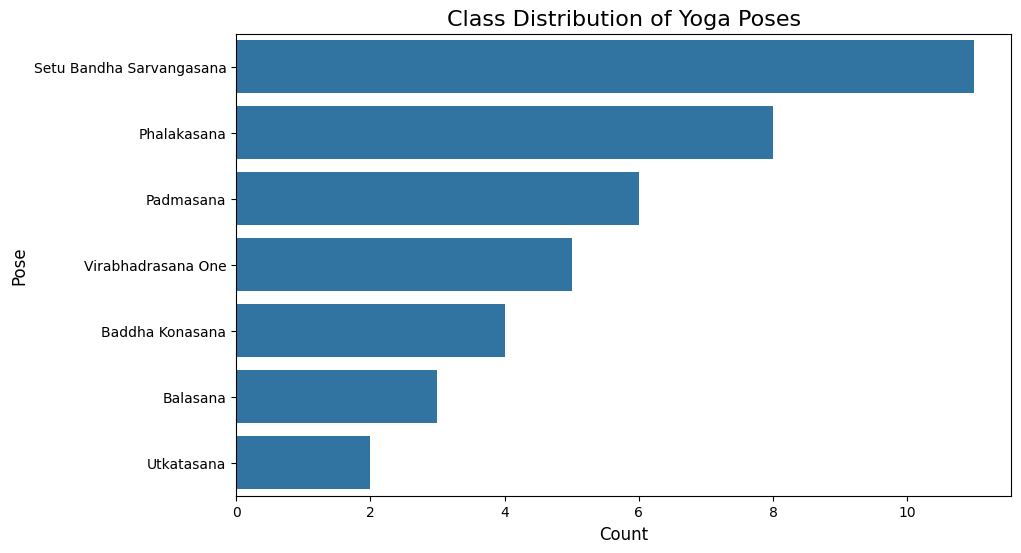

In [11]:
# ## 3. Data Cleaning and EDA
# 클래스별 샘플 수 확인 및 2개 미만인 클래스 제거
label_counts = df['label'].value_counts()
print("Original class counts:\n", label_counts)
classes_to_remove = label_counts[label_counts < 2].index.tolist()

if classes_to_remove:
  print(f"\nWarning: Classes with fewer than 2 samples will be removed: {classes_to_remove}")
  df = df[~df['label'].isin(classes_to_remove)].reset_index(drop=True)
  class_names = sorted(df['label'].unique().tolist())
  print(f"Data shape after removing small classes: {df.shape}")

# 클래스 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
plt.title('Class Distribution of Yoga Poses', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Pose', fontsize=12)
plt.show()

In [12]:
# ## 4. Data Splitting and Augmentation (수정된 부분)
# 데이터가 적으므로 Train과 Validation 세트로만 분할 (80% / 20%)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"\nTraining samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# ImageDataGenerator 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# 검증/테스트 데이터는 rescale만 적용
val_datagen = ImageDataGenerator(rescale=1./255)

# 제너레이터 생성
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16 # 데이터가 적으므로 배치 사이즈 줄임

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=class_names
)

# 검증과 테스트에 동일한 데이터셋 사용
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=class_names,
    shuffle=False
)

test_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df, # 검증 데이터셋을 테스트에도 사용
    x_col='path',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=class_names,
    shuffle=False
)



Training samples: 31
Validation samples: 8
Found 31 validated image filenames belonging to 7 classes.
Found 8 validated image filenames belonging to 7 classes.
Found 8 validated image filenames belonging to 7 classes.


In [13]:
# ## 5. Model Building (Transfer Learning with MobileNet)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,285,639 (16.35 MB)

 Trainable params: 1,056,775 (4.03 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [14]:
# ## 6. Model Training
if len(train_df) > BATCH_SIZE and len(val_df) > 0:
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator,
        callbacks=[early_stopping]
    )
else:
    print("\nNot enough data to train the model after splitting. Please add more images.")
    history = None

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 18s/step - accuracy: 0.1284 - loss: 3.2027 - val_accuracy: 0.2500 - val_loss: 4.0128
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step - accuracy: 0.5204 - loss: 2.9326 - val_accuracy: 0.3750 - val_loss: 2.2403
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step - accuracy: 0.8293 - loss: 0.7723 - val_accuracy: 0.5000 - val_loss: 1.1283
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 417ms/step - accuracy: 0.8480 - loss: 0.4102 - val_accuracy: 0.3750 - val_loss: 1.4119
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step - accuracy: 0.9563 - loss: 0.1612 - val_accuracy: 0.6250 - val_loss: 1.0650
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step - accuracy: 1.0000 - loss: 0.0888 - val_accuracy: 0.5000 - val_loss: 1.3151
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step - accuracy: 1.0000 - loss: 0.0927 - val_accuracy: 0.6250 - val_loss: 1.3161
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step - accuracy: 0.9785 - loss: 0.1387 - val_accuracy: 0.5000 - val_loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7500 - loss: 0.4216

Test Accuracy: 75.00%


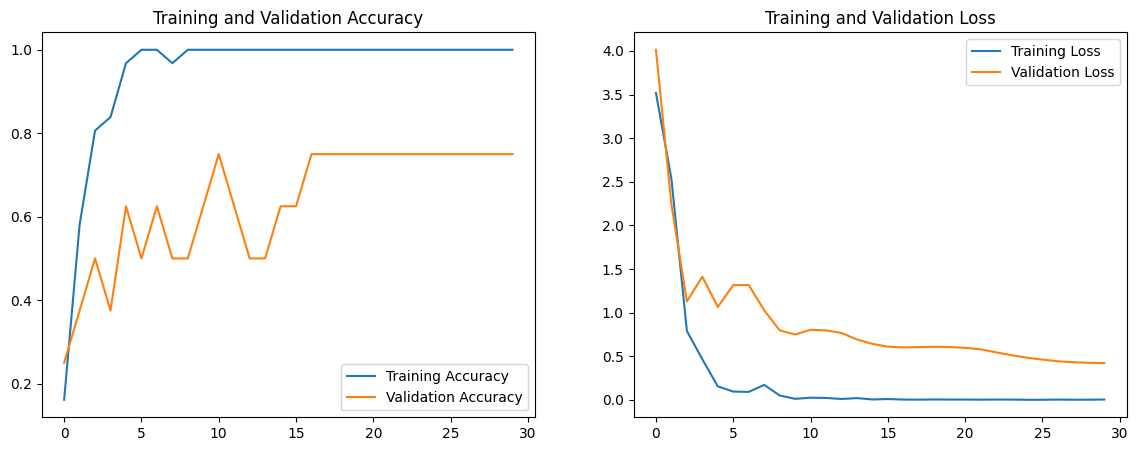

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


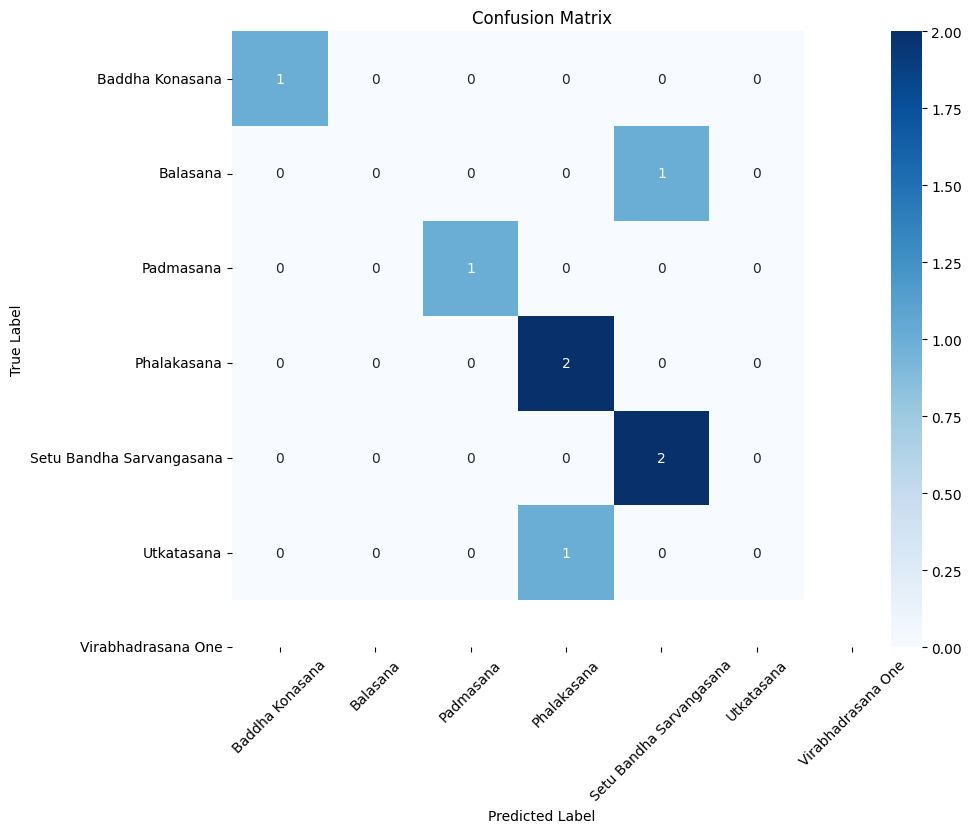

In [16]:
# ## 7. Performance Evaluation
if not df.empty and history is not None:
    loss, accuracy = model.evaluate(test_generator)
    print(f'\nTest Accuracy: {accuracy*100:.2f}%')

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = test_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

                          precision    recall  f1-score   support

         Baddha Konasana       1.00      1.00      1.00         1
                Balasana       0.67      1.00      0.80         2
               Padmasana       0.67      1.00      0.80         2
             Phalakasana       0.00      0.00      0.00         0
Setu Bandha Sarvangasana       0.00      0.00      0.00         1
              Utkatasana       0.00      0.00      0.00         0
      Virabhadrasana One       0.00      0.00      0.00         0

               micro avg       0.71      0.83      0.77         6
               macro avg       0.33      0.43      0.37         6
            weighted avg       0.61      0.83      0.70         6


Total misclassified images: 2



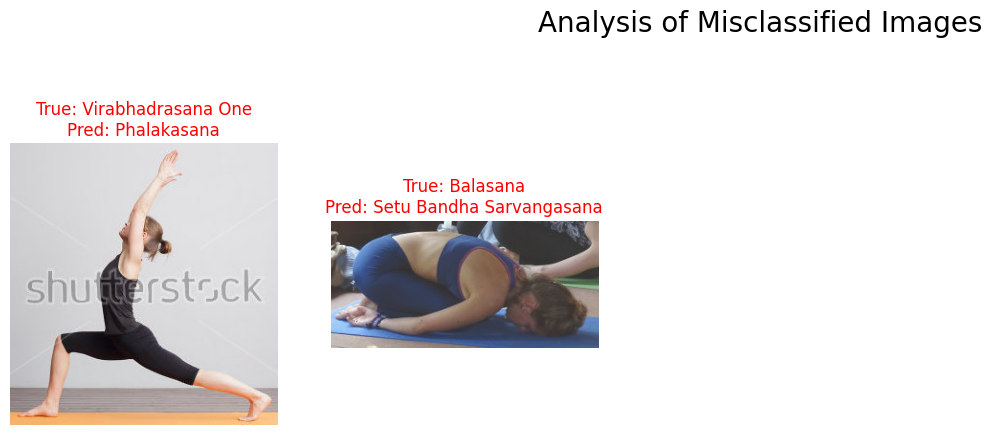

In [19]:
# 수정된 부분: labels 파라미터를 추가하여 전체 클래스에 대한 리포트 생성
report_labels = le.transform(class_names)
print(classification_report(y_true, y_pred, target_names=class_names, labels=report_labels))

misclassified_indices = np.where(y_pred != y_true)[0]
if len(misclassified_indices) > 0:
    print(f"\nTotal misclassified images: {len(misclassified_indices)}\n")
    plt.figure(figsize=(20, 10))
    random_indices = np.random.choice(misclassified_indices, size=min(10, len(misclassified_indices)), replace=False)

    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        img_path = test_generator.filepaths[idx]
        img = plt.imread(img_path)
        plt.imshow(img)
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=12, color='red')
        plt.axis('off')
    plt.suptitle('Analysis of Misclassified Images', fontsize=20)
    plt.show()